# **CNN - SOTAs**

> Session 6: Comparing different architectures!

In this exercise, we'll be looking at some of the more popular SOTAs for image recognition. We shall learn how to predict the 'imagenet' class of any given image and also plot the saliency map for it.



In [1]:
# importing the required libraries
!pip -qq install tf_keras_vis 
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import pandas as pd
import numpy as np
import seaborn as sns
import warnings
import cv2
import glob
import os
import pickle
import zipfile
import tensorflow as tf
from tensorflow.keras import layers
from __future__ import print_function
from keras.models import Model, Sequential, load_model
from keras.layers import Dense, Input, Conv2D, MaxPooling2D, Flatten, Dropout
from keras.datasets import cifar10
from keras.optimizers import Adam
from keras.preprocessing import image
from keras.applications.vgg16 import VGG16
from keras.applications.inception_v3 import InceptionV3
from keras.applications.resnet50 import ResNet50
from keras.applications.mobilenet_v2 import MobileNetV2
from keras.applications import imagenet_utils
from keras.preprocessing.image import ImageDataGenerator
from tf_keras_vis.saliency import Saliency
from tf_keras_vis.utils import normalize
from PIL import Image
warnings.filterwarnings('ignore')
pd.options.display.float_format = '{:,.2f}'.format
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 200)

## Downloading the data

We shall also see how these architectures predict on four random images. Let's download the images from the link below

In [2]:
# downloading the images required

img_path = './random_images/images/'
!gdown https://drive.google.com/uc?id=1HLeOlu5mj3ipuMs4XFkMQq9CsuZFoSJ2
!unzip -qq random_images.zip

Downloading...
From: https://drive.google.com/uc?id=1HLeOlu5mj3ipuMs4XFkMQq9CsuZFoSJ2
To: /content/random_images.zip
100% 346k/346k [00:00<00:00, 46.2MB/s]


In [3]:
# choosing 4 random images for predicting

img1 = 'harry_potter.jpg'
img2 = 'lamborghini.jpg'
img3 = 'catdog.jpeg'
img4 = 'airplane.jpg'

imgs = [img1,img2,img3,img4]

In [4]:
# defining a function that takes an image, preprocesses it and converts it into a tensor 
# which can be used by the predict function
def prepare_image(file, row, height):
  img = image.load_img(img_path + file, target_size=(row, height))
  # height, width, channels
  img_array = image.img_to_array(img)                                  
  # (batch_size, height, width, channels), add a dimension because Keras works with batches of images
  img_array_expanded_dims = np.expand_dims(img_array, axis=0)           
  # the preprocess function adequates your image to the format that the model requires
  return preprocess_input(img_array_expanded_dims)                      

# defining a function to predict & display the top 5 Imagenet classes along with their probabilities
def predict_image(model, row, height):
  fig, axs = plt.subplots(2, len(imgs), figsize = (20,10))
  for i,img in enumerate(imgs):
    axs[0, i].imshow(Image.open(img_path+img).resize((200, 200), Image.ANTIALIAS))
    preprocessed_img = prepare_image(img, row, height)
    # decode_predictions gives the top 5 classes from the imagenet classes 
    pred_img = imagenet_utils.decode_predictions(model.predict(preprocessed_img))[0]      
    #bar plot the predictions  
    barp = sns.barplot(y=[c[1] for c in pred_img], x=[c[2]*100 for c in pred_img], color="gray", ax=axs[1, i])
    barp.tick_params(labelsize=10)
    fig.tight_layout()
  for ax in axs[0,:]:
    ax.axis('off')
  plt.show()

## VGG16 - PreTrained Model

As discussed in lecture, VGG-16 is a simpler architecture model, since its not using much hyper parameters. It always uses 3 x 3 filters with stride of 1 in convolution layer and uses SAME padding in pooling layers 2 x 2 with stride of 2.

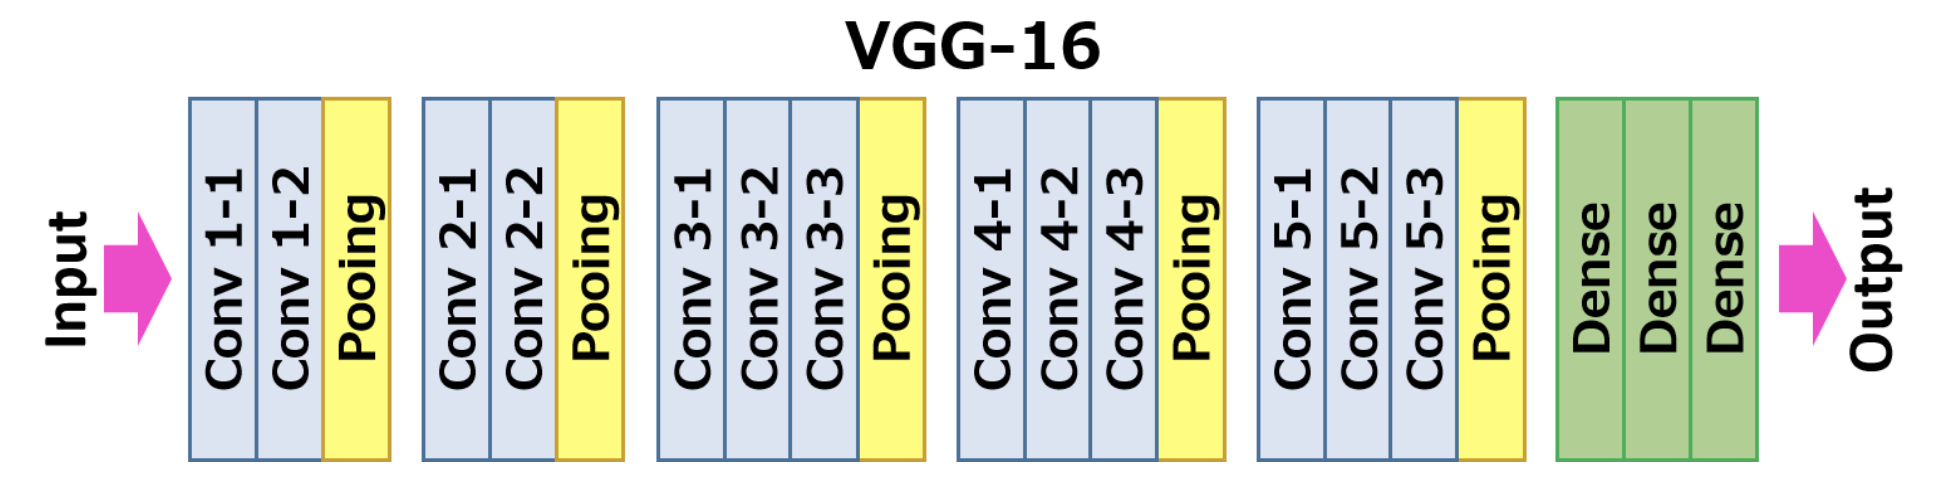

In [5]:
# We will be used pre-trained model here
# Getting the vgg model from the keras api

vgg = VGG16(weights='imagenet',include_top=True)
vgg.summary()

553467904/553467096 [==============================] - 3s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
____________________________________________________________

Let's call the **predict_image** function to display the predictions for the 4 images.

Note - We'll need to import the preprocess_input function separately for the different architectures. Some models use images with values ranging from 0 to 1. Others from -1 to +1. Others, like ResNet, use the "caffe" style, that is not normalized, but is centered.

40960/35363 [==================================] - 0s 0us/step


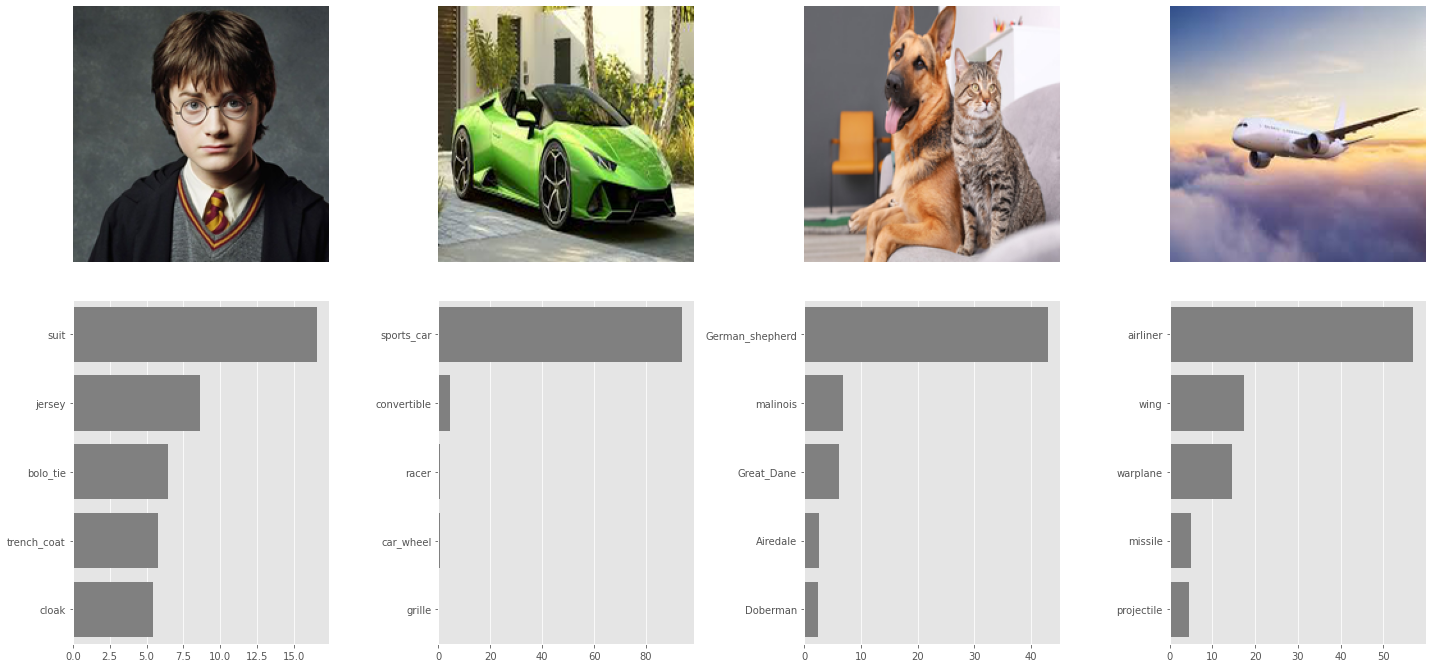

In [6]:
# Importing the preprocess_input function for vgg16 and using the 'predict_image' 
# function to display the top 5 predicted classes
from keras.applications.vgg16 import preprocess_input
predict_image(vgg,224,224)

### Saliency Maps

Let's have a look at how the Saliency maps differ for the different classes. Later we will also compare them against Saliency maps obtained from the other architectures

In [7]:

# Define a function here to replace "Softmax activation" of the final dense layer with "linear" as we want the class scores, not the class
def model_modifier(m):
  m.layers[-1].activation=tf.keras.activations.linear
  return m
  
# Defining a function to generate saliency graphs for the top 5 predicted classes
def saliency_graphs(model, img, row, height):

  # Create Saliency object
  saliency = Saliency(model, model_modifier)

  # input image that is pre-processed
  input_image =  prepare_image(img,row,height)

  # predict on the input image
  y_pred = model.predict(input_image)

  # return the indices in decreasing order of predicted probability
  class_idxs_sorted = np.argsort(y_pred.flatten())[::-1]

  for i, class_idx in enumerate(class_idxs_sorted[:5]):

    # Define loss function for the class label.
    # The 'output' variable refer to the output of the model
    loss = lambda output: tf.keras.backend.mean(output[:, class_idx])   

    # Generate saliency map with smoothing. Smoothing reduces noise in the Saliency map
    # smooth_samples is the number of calculating gradients iterations
    saliency_map = saliency(loss, input_image[0,...], smooth_samples=20)    
    saliency_map = normalize(saliency_map)
    plot_saliency_map(saliency_map,img,y_pred,i,class_idx)


# Defining a function to plot saliency map
def plot_saliency_map(sal_map, img, y_pred, i, class_idx):

  fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
  ax[0].imshow(Image.open(img_path+img).resize((200, 200), Image.ANTIALIAS))
  j = ax[1].imshow(sal_map[0],cmap="jet",alpha=0.8)
  fig.colorbar(j)
  for axe in ax:
    axe.grid(False)
    axe.axis('off')
  plt.suptitle("Pr(class={}) = {:5.2f}".format(imagenet_utils.decode_predictions(y_pred)[0][i][1],y_pred[0,class_idx]))


Let's create the Saliency maps forthe Cat & Dog image (`img3`)

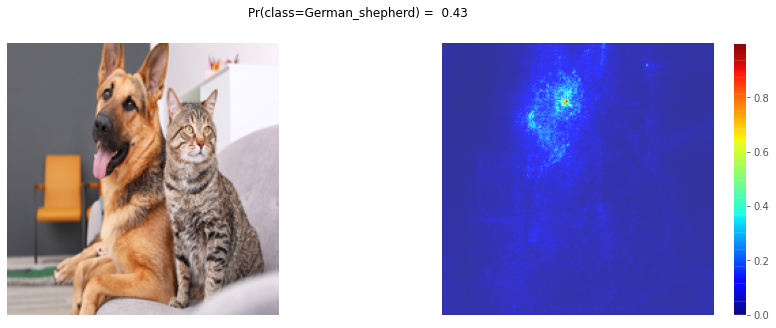

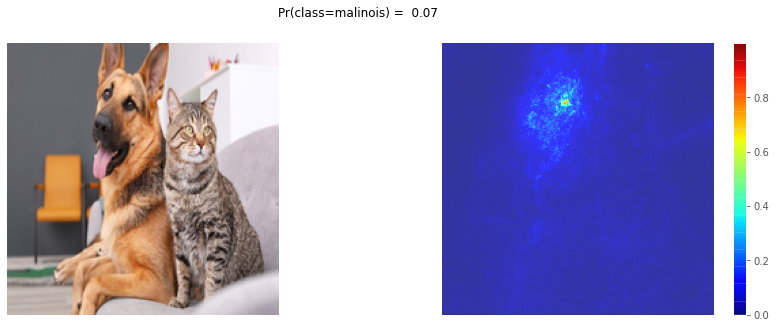

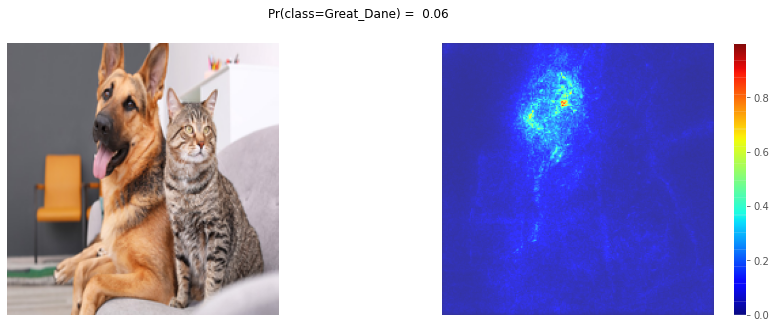

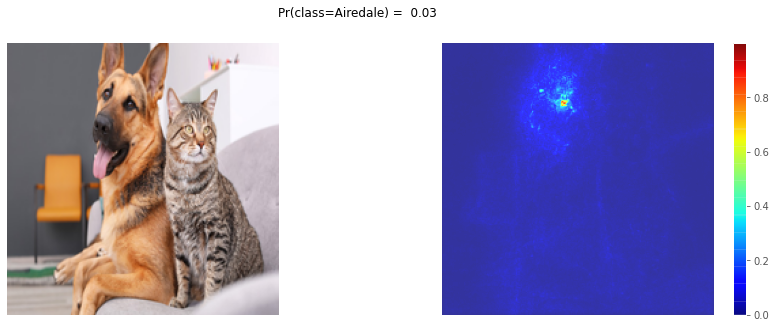

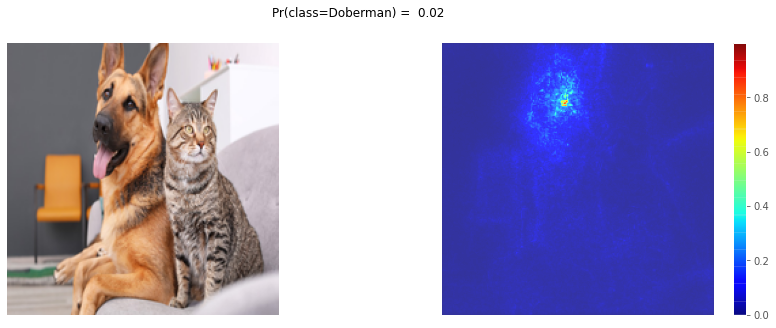

In [8]:
# Generate saliency graphs by calling the helper functions for 'img3' for vgg model
saliency_graphs(vgg,img3,224,224)

Try the same out for the airplane image. What do you notice?

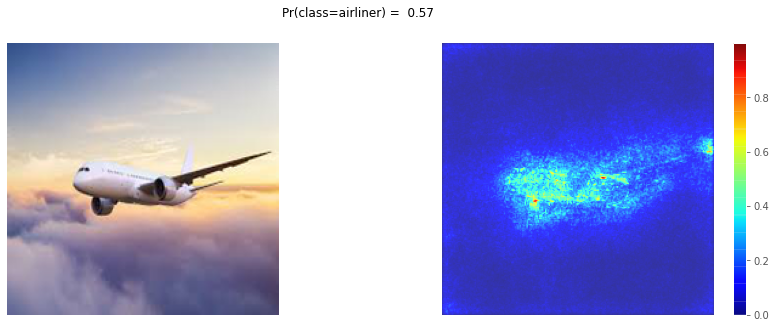

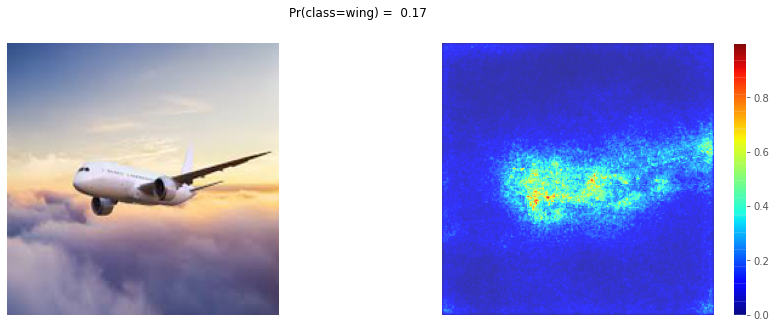

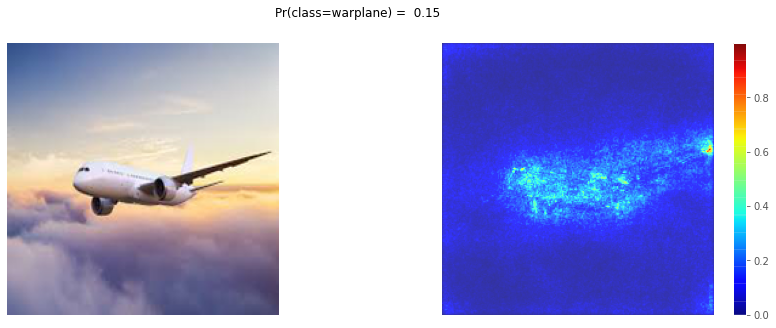

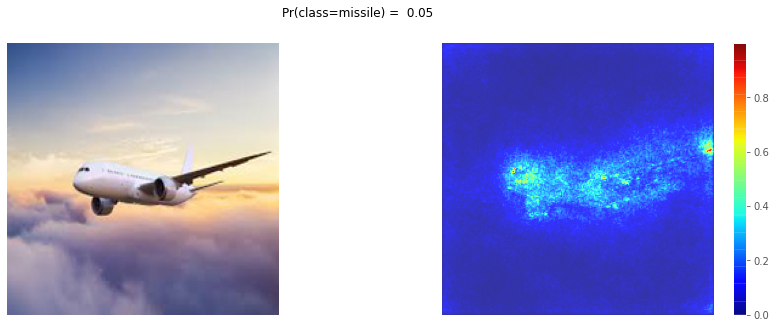

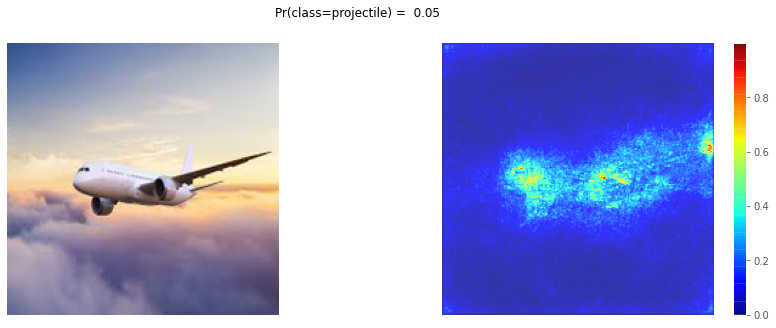

In [9]:
saliency_graphs(vgg,img4,224,224)

## InceptionNetV3 - PreTrained Model

Now let try this out for the InceptionNetV3 model. To read more about InceptionNetV3 model [read this](https://cloud.google.com/tpu/docs/inception-v3-advanced#:~:text=found%20on%20GitHub.-,Introduction,accuracy%20on%20the%20ImageNet%20dataset.&text=It%20is%20based%20on%20the,Vision%22%20by%20Szegedy%2C%20et.)

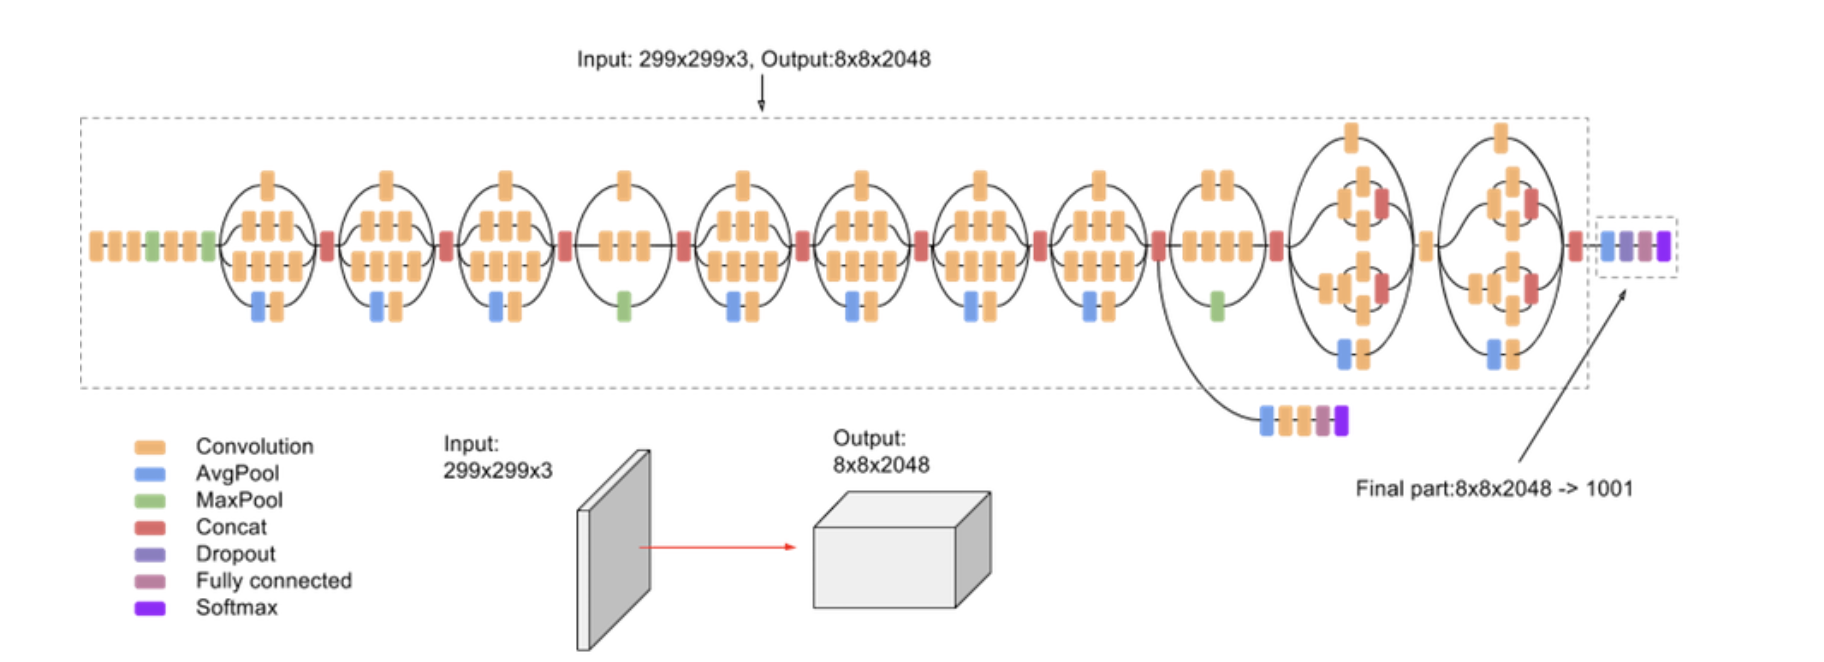



In [10]:
# Get the inception model from the keras api

inception_model = InceptionV3(weights='imagenet',include_top=True)
inception_model.summary()

96116736/96112376 [==============================] - 1s 0us/step
Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 149, 149, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 149, 149, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 149, 149, 32) 0           batch_normalization[0][0]        
______________________

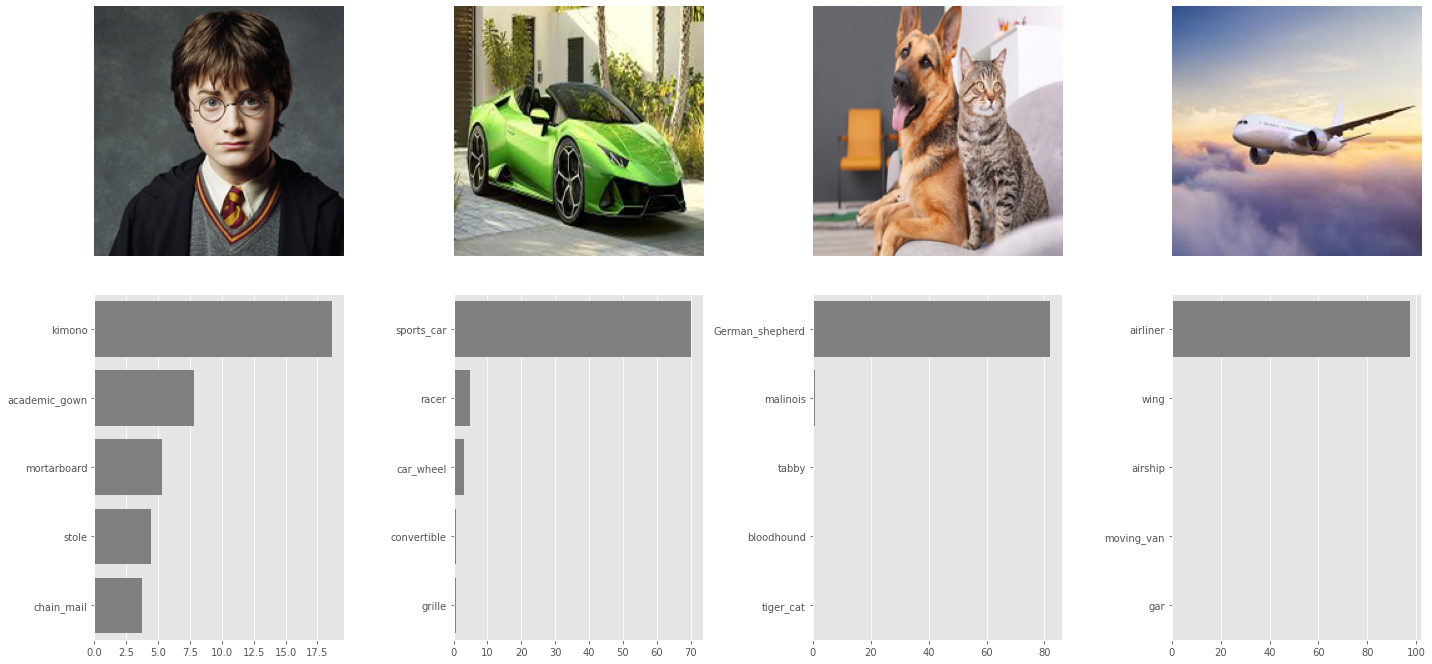

In [11]:
# Import the preprocess_input function for inception_v3 and display the top 5 predictions for each of the 4 images
from keras.applications.inception_v3 import preprocess_input
predict_image(inception_model,299,299)

### Saliency graphs

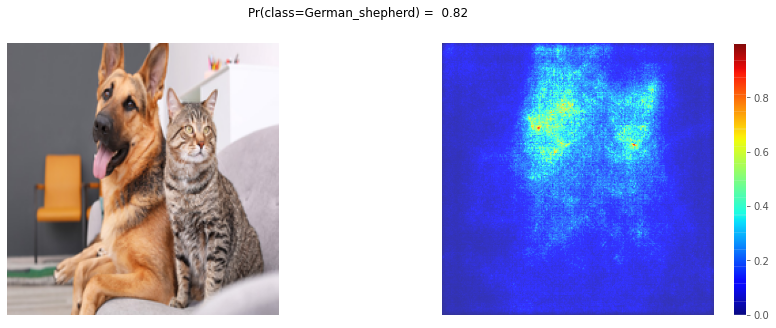

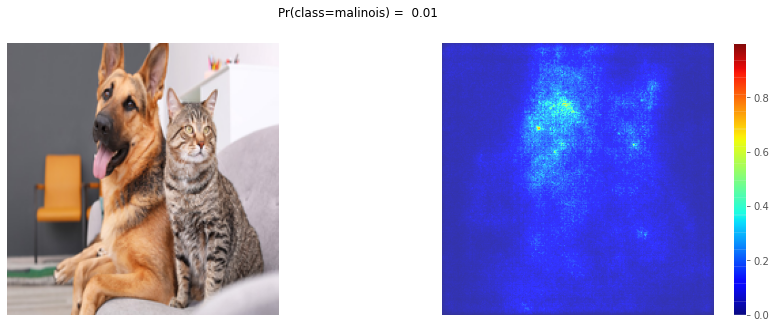

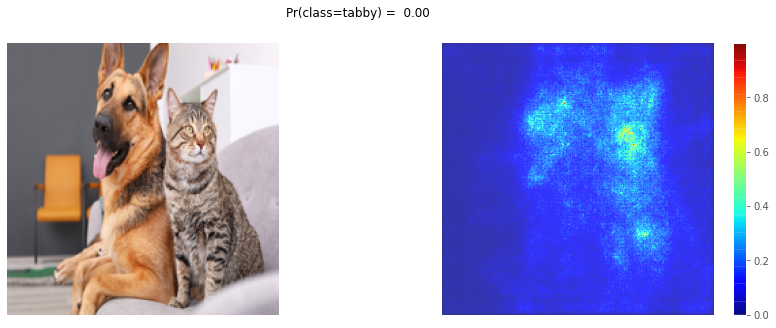

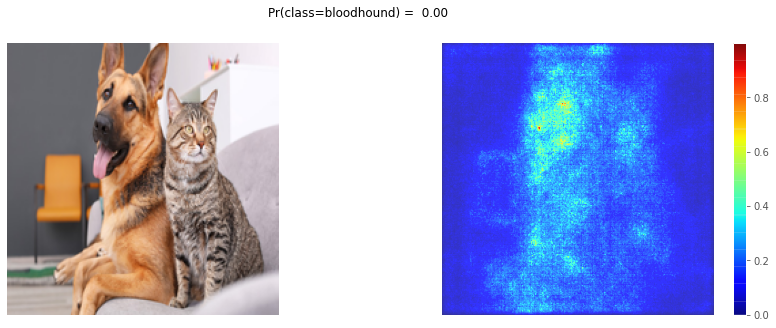

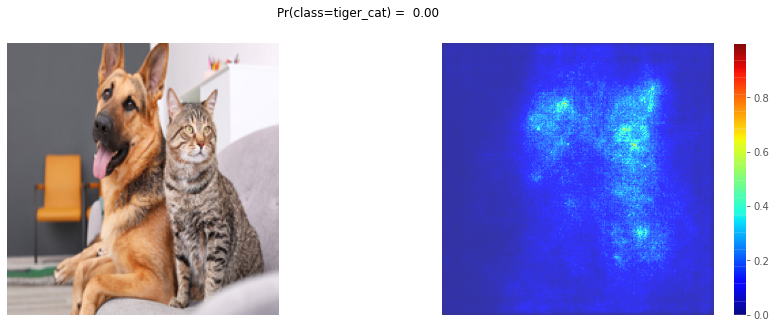

In [13]:
# Generate saliency graphs by calling the helper functions for 'img3' for inception_v3 model
saliency_graphs(inception_model,img3,299,299)

## ResNet50 - PreTrained Model

Lets try this with ResNet50 model 
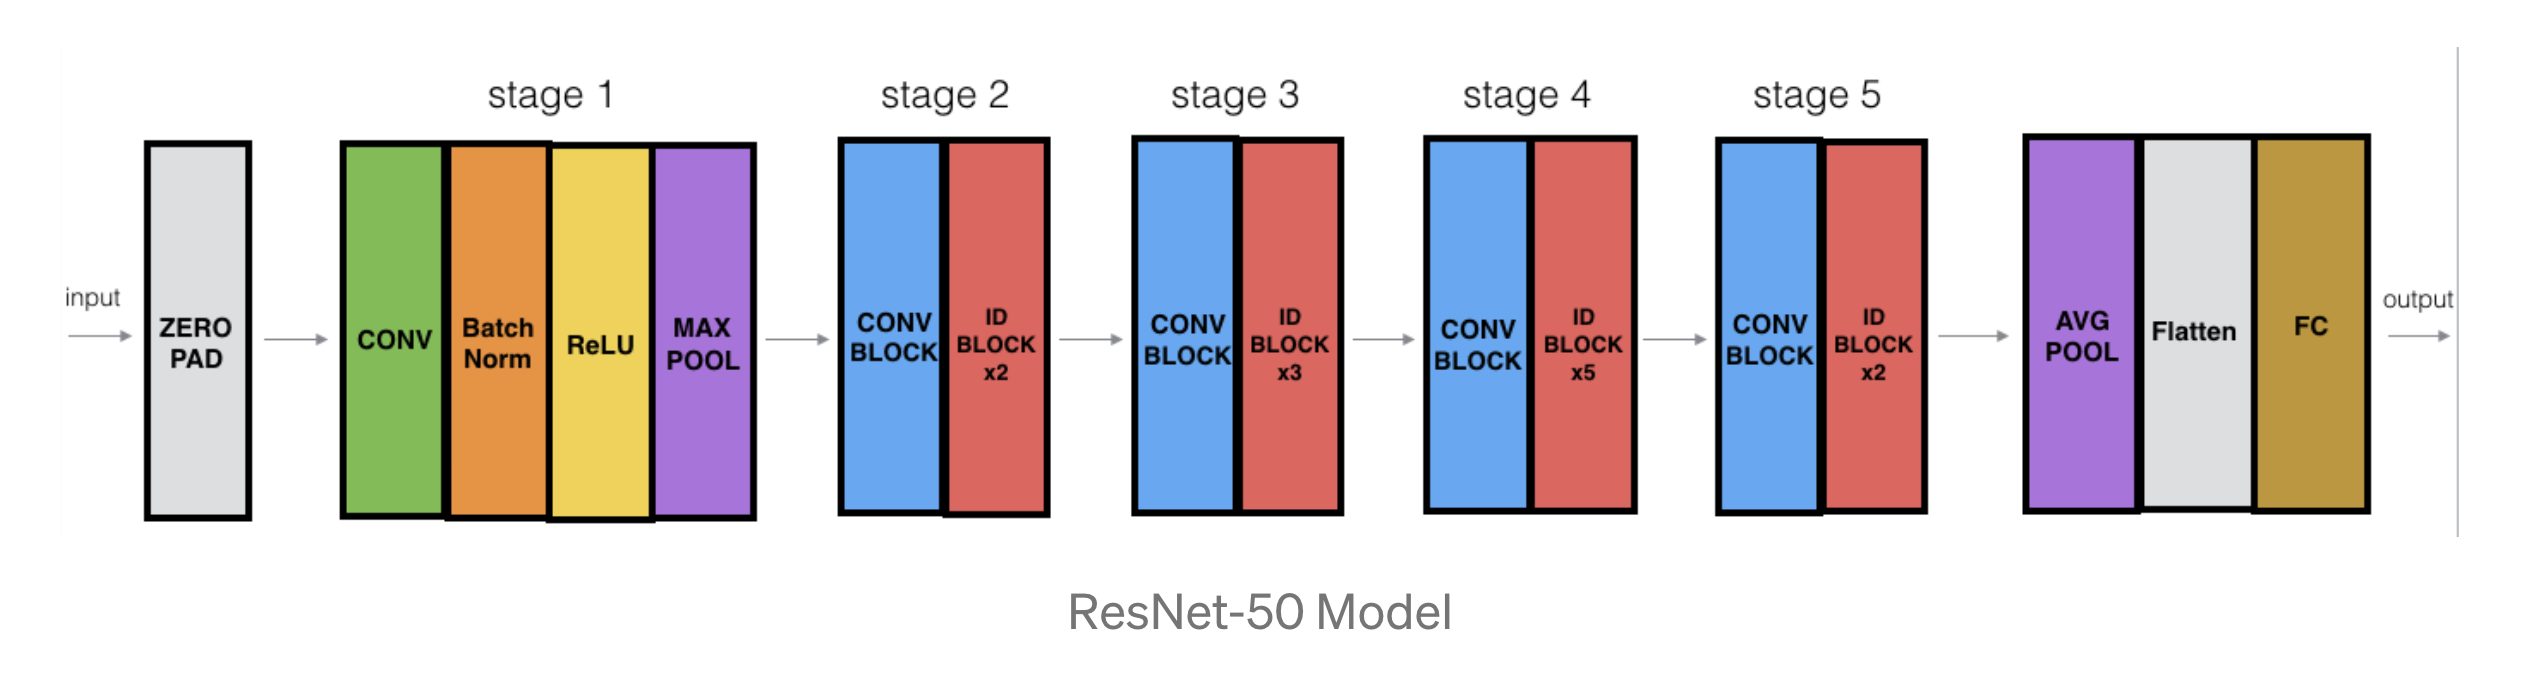

In [14]:
# Getting the ResNet50 model from the keras api

resnet_model = ResNet50()
resnet_model.summary()

102973440/102967424 [==============================] - 2s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
________________________

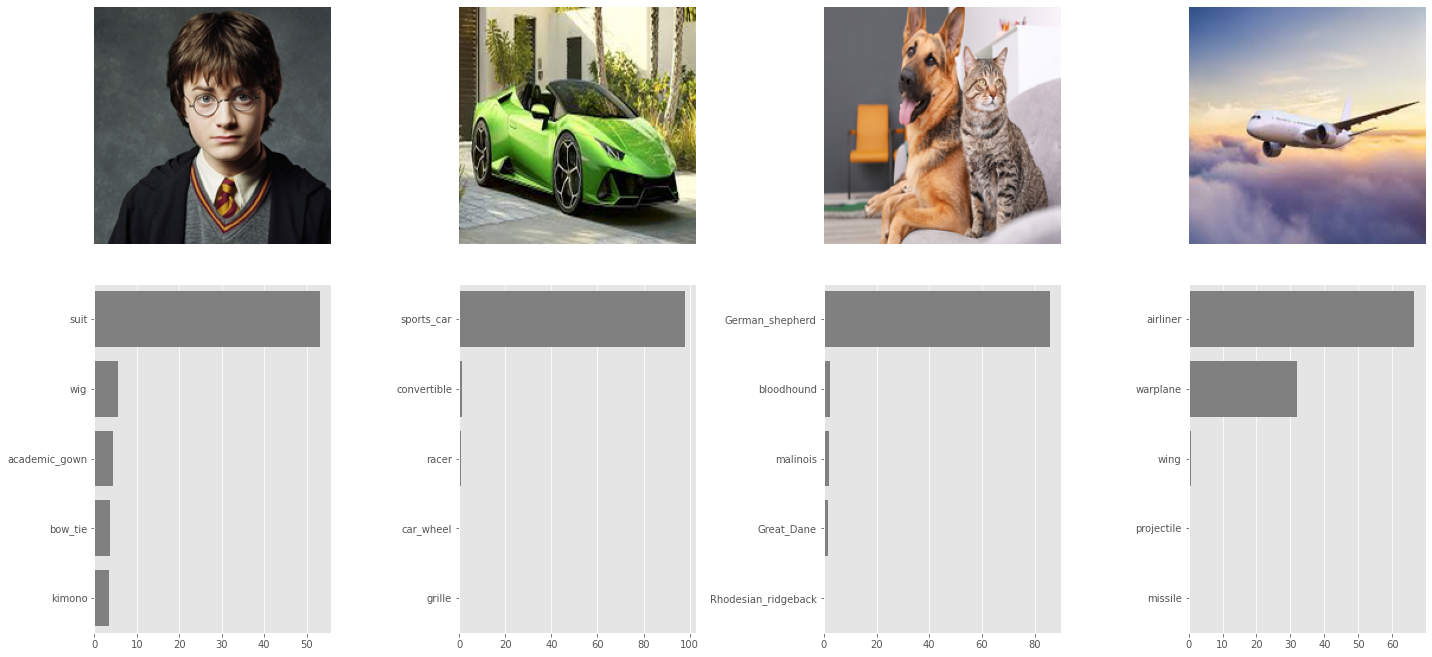

In [15]:
# Import the preprocess_input function for ResNet50 and display the top 5 predictions for each of the 4 images
from keras.applications.resnet50 import preprocess_input
predict_image(resnet_model,224,224)

### Saliency Maps

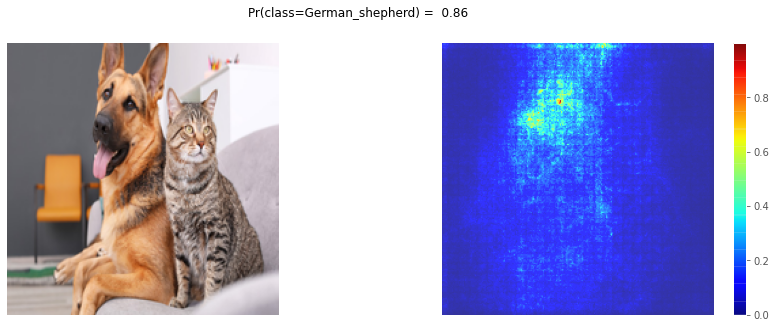

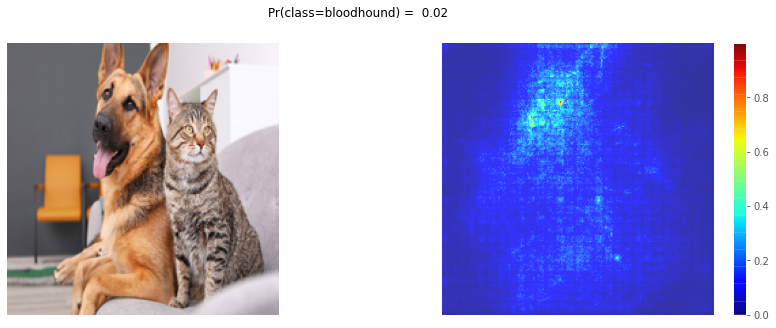

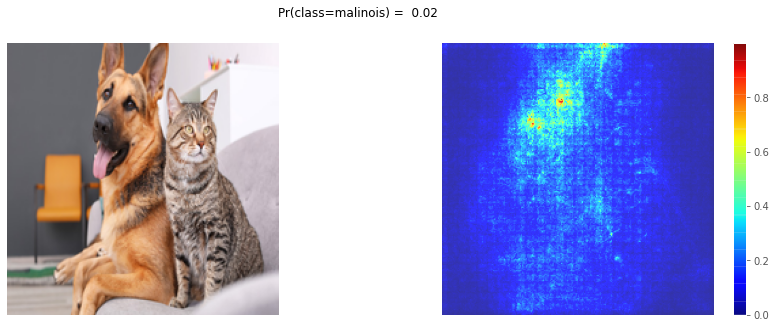

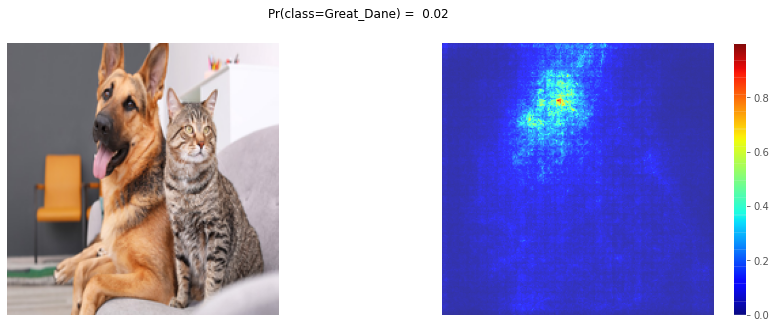

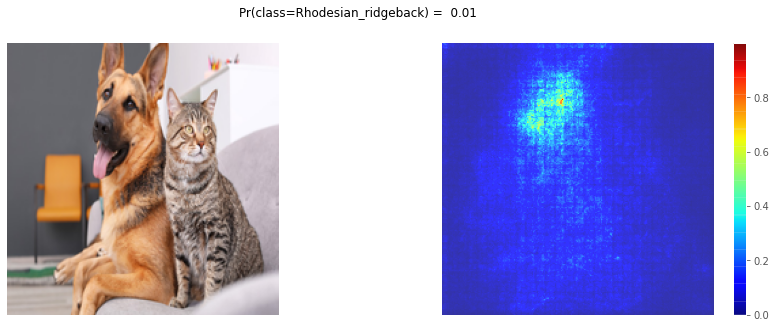

In [16]:
# Generate saliency graphs by calling the functions for 'img3' for ResNet50 model
saliency_graphs(resnet_model,img3,224,224)

## MobileNetV2 PreTrained Model
To learn more about MobileNetV2 [read this](https://ai.googleblog.com/2018/04/mobilenetv2-next-generation-of-on.html)

In [17]:
# Getting the mobilenet_v2 model from the keras api
mobilenetv2_model = MobileNetV2()
mobilenetv2_model.summary()

14540800/14536120 [==============================] - 0s 0us/step
Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_4[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
______________

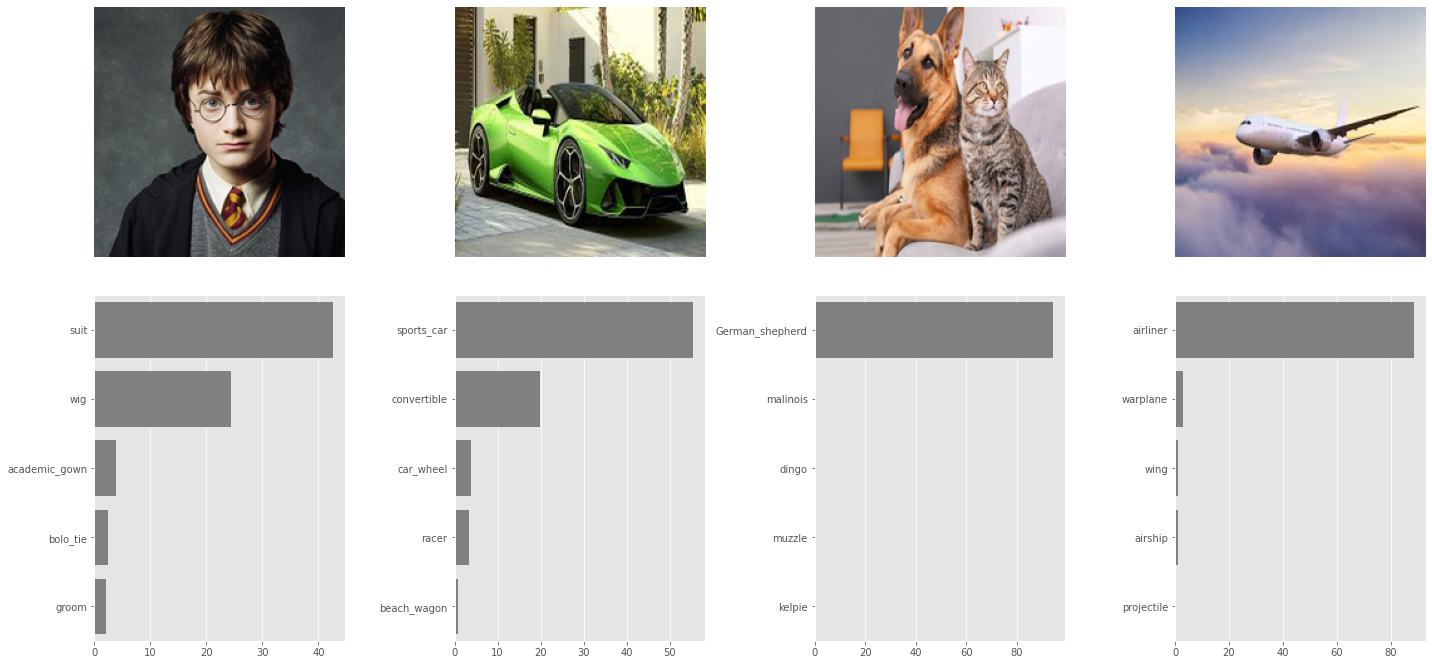

In [18]:
# Import the preprocess_input function for mobilenet_v2 and display the top 5 predictions for each of the 4 images
from keras.applications.mobilenet_v2 import preprocess_input
predict_image(mobilenetv2_model,224,224)

### Saliency Maps

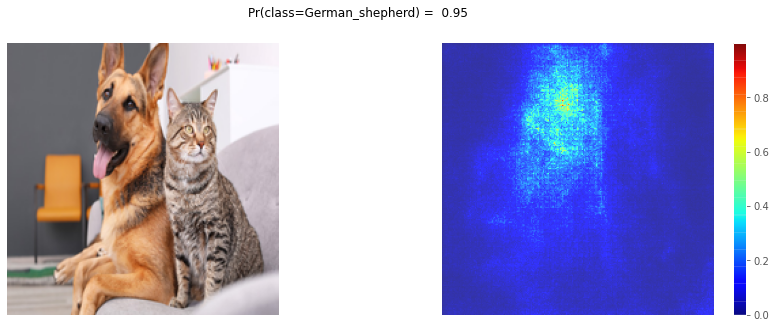

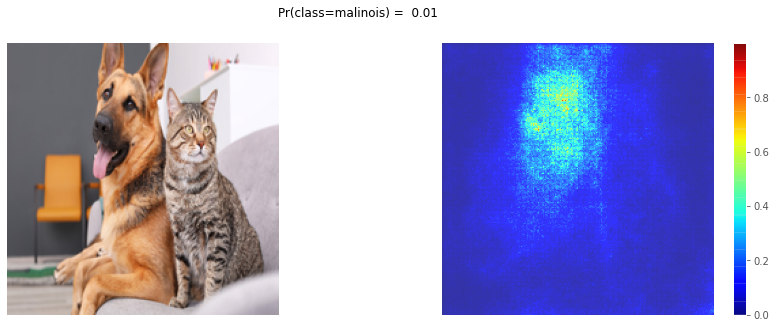

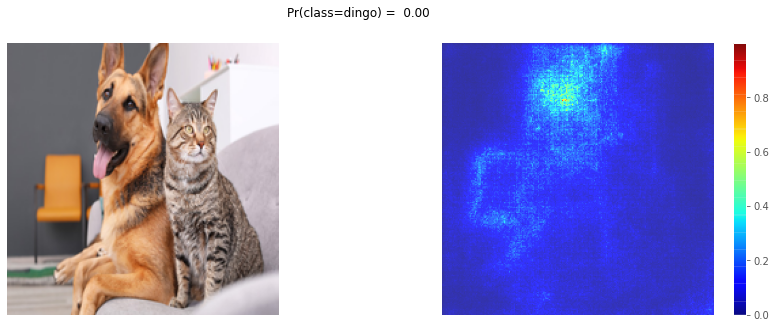

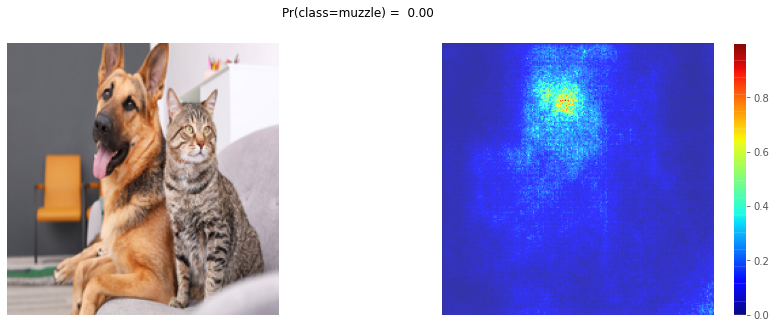

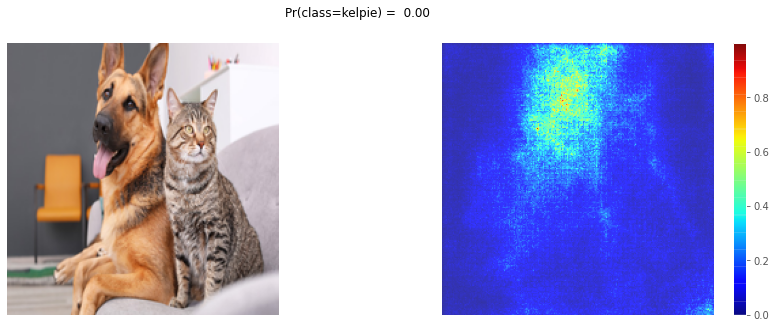

In [19]:
# Generate saliency graphs by calling the helper functions for 'img3' for mobilenet_v2 model
saliency_graphs(mobilenetv2_model,img3,224,224)

# Mindchow


1.   Check the saliency maps of the other 3 images. 
2.   Predict the classes by using Xception and Wide Residual Networks (WRN) on the same images. See how their Saliency maps differ.
3. Which model according to you performed better?

Now that you have done your analysis, check out the how the different SOTA architectures based on their computational complexity and accuracy on the *ImageNet* Validation set of 1k images. You want the best accuracy at the lowest complexity

![pic](https://drive.google.com/uc?id=17tO0Z_awRrghoyTErG5nRAzWs5zwmnHj)